# CSS5228 Final Project

In this notebook, we will start training our model

| Model | Params | RMSE |
| --- | --- | --- |
| Random Forest | Default | 1578054.3837494547 |
| LGBM | Default | 1483166.5956031918 |
| Catboost | Default | 1477341.942214399 |
| XGBoost | Default | 1527868.5405417508 |
| GradientBoosting | Default | 1759321.2921611383 |

In [61]:
import pandas as pd
import numpy as np
from pathlib import Path
from math import sqrt

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

import mlflow
import optuna
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

from utils import highlight_top, save_fig


In [15]:
pd.set_option('display.max_columns', None)

In [44]:
df_train = pd.read_csv("../clean_data/train_preproc.csv", index_col=0)
df_test = pd.read_csv("../clean_data/test_preproc.csv", index_col=0)
df_submission = pd.read_csv("../raw_data/example-submission.csv")

In [45]:
X = df_train.drop(["price"], axis=1)
y = df_train["price"]

In [48]:
sns.set_theme(style="ticks")
sns.set_context("paper", rc={"xtick.labelsize":15,
                             "ytick.labelsize":15,
                             "axes.titlesize":20,
                             "axes.labelsize":15})
default_col = '#4c72b0'
highlight_col = '#c44d52'

img_dir = Path("../images/")

## Model Training

- We will start off with ensemble tree methods since it doesn't require standardization and performs relatively well.
- We will also be able to leverage on the feature importance function to have a sense of how each feature is performing

In [97]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

print("Size of training set: {}".format(len(X_train)))
print("Size of test: {}".format(len(X_valid)))
print(len(X_valid), len(y_valid))

Size of training set: 13931
Size of test: 3483
3483 3483


In [98]:
fold_score = []
feat_importance = pd.DataFrame(index = X.columns)
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

In [99]:
%%time

max_depth = 10

ds, ns, rmse = [], [], []

# Loop over all values for max_depth
for d in range(1, max_depth+1):
    for n in [10, 25, 50, 100]:
        ds.append(d)
        ns.append(n)    
        # Train Decision Tree classifier for current value of max_depth
        clf = LGBMRegressor(max_depth=d, n_estimators=n).fit(X_train, y_train)
        # Predict class labels for test set
        y_pred = clf.predict(X_valid)
        # Calculate f1 score between predictions and ground truth
        rmse_score = sqrt(mean_squared_error(y_valid, y_pred))
        rmse.append(rmse_score)

Wall time: 5.9 s


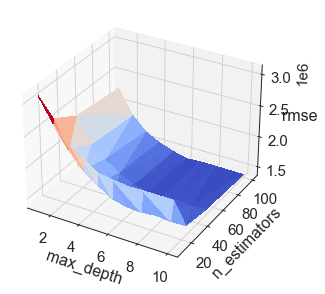

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'max_depth', fontsize=16)
ax.set_ylabel(r'n_estimators', fontsize=16)
ax.set_zlabel('rmse', fontsize=16)

surf = ax.plot_trisurf(ds, ns, rmse, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
plt.tight_layout()
plt.show()

In [102]:
rmse_min = np.min(rmse)

print('The lowest rmse score across all runs: {:.3f}'.format(rmse_min))

The lowest rmse score across all runs: 1391926.907


In [103]:
best_runs = np.where(rmse == rmse_min)[0]

print('The following runs resulted in the lowest rmse score of {:.4f}'.format(rmse_min))
for run in best_runs:
    print('* max_depth = {}, n_estimators = {}'.format(ds[run], ns[run]))

The following runs resulted in the lowest rmse score of 1391926.9074
* max_depth = 6, n_estimators = 100


In [113]:
for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
    print("\nFold {}".format(fold+1))
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    model = LGBMRegressor(max_depth=6, n_estimators=250)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    feat_importance["Importance_Fold"+str(fold)] = model.feature_importances_
    
    rmse_score = sqrt(mean_squared_error(y_val, y_pred))
    fold_score.append(rmse_score)
    print("Validation RMSE = {:.4f}".format(rmse_score))
print("================================")
print("RMSE = {}".format(np.mean(fold_score)))



Fold 1
Train shape: (13931, 38), (13931,), Valid shape: (3483, 38), (3483,)
Validation RMSE = 1367117.4218

Fold 2
Train shape: (13931, 38), (13931,), Valid shape: (3483, 38), (3483,)
Validation RMSE = 1619503.5154

Fold 3
Train shape: (13931, 38), (13931,), Valid shape: (3483, 38), (3483,)
Validation RMSE = 1573546.6352

Fold 4
Train shape: (13931, 38), (13931,), Valid shape: (3483, 38), (3483,)
Validation RMSE = 1307196.5642

Fold 5
Train shape: (13932, 38), (13932,), Valid shape: (3482, 38), (3482,)
Validation RMSE = 1488517.0973
RMSE = 1483166.5956031918


In [114]:
average_importance = np.mean(feat_importance, axis=1)
average_importance = average_importance.reset_index()
average_importance = average_importance.rename(columns={0:"mean_importance"})
average_importance["mean_importance"] = round(average_importance["mean_importance"], 5)
average_importance = average_importance.sort_values(by=["mean_importance"], ascending=False)

Saving figure feature_importance


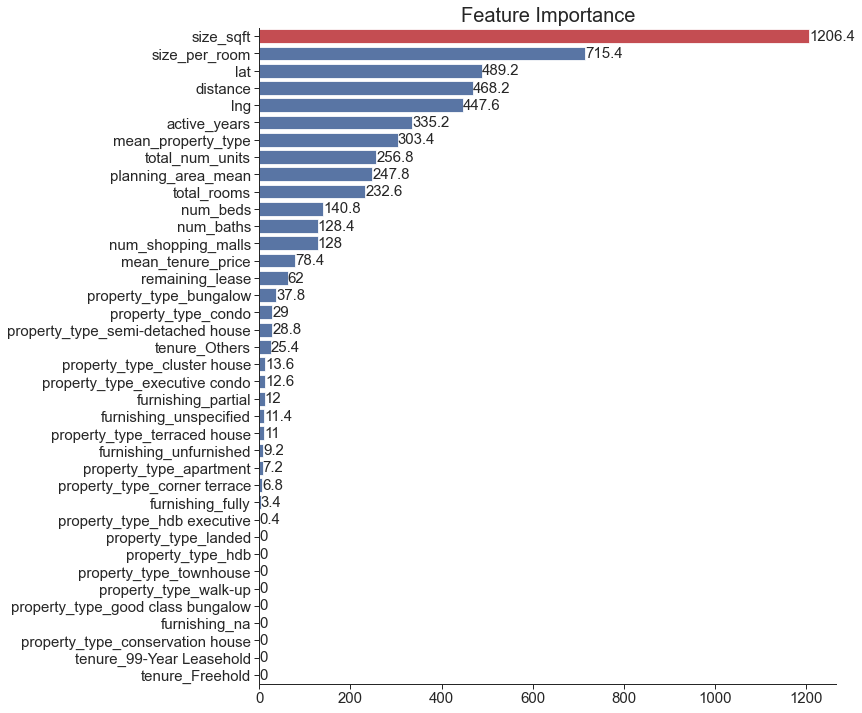

In [115]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x="mean_importance", y="index", data=average_importance, color=default_col)
ax.bar_label(ax.containers[0], fontsize=15)
sns.despine()
highlight_top(ax, "horizontal", highlight_col)
plt.title("Feature Importance")
plt.xlabel("")
plt.ylabel("")
save_fig("feature_importance", img_dir)
plt.show()


In [116]:
pred = model.predict(df_test)

In [117]:
df_submission["Predicted"] = pred

In [118]:
df_submission.to_csv("../lgbm_tuned_submission.csv", index=0)

## Hyperparameter Tuning

In [1]:
# mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow.set_experiment("cs5228-price-regression-3")

In [96]:
def optimize(params, x, y):
    fold_score = []
    k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for fold, (train_idx, val_idx) in enumerate(k_fold.split(X, y)):
        
        #print("\nFold {}".format(fold+1))
        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_val, y_val = X.iloc[val_idx,:], y[val_idx]
        #print("Train shape: {}, {}, Valid shape: {}, {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
        
        model = LGBMRegressor().fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        feat_importance["Importance_Fold"+str(fold)] = model.feature_importances_
        
        rmse_score = sqrt(mean_squared_error(y_val, y_pred))
        fold_score.append(rmse_score)
        print("Validation RMSE = {:.4f}".format(rmse_score))
    print("================================")
    print("RMSE = {}".format(np.mean(fold_score)))
    return np.mean(fold_score)

In [252]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1500, 1)),
    'random_state': 42
    }

In [253]:
optimization_function = partial(optimize,
                                x=X,
                                y=y)

In [254]:
rstate = np.random.default_rng(42)  # for reproducible results

hopt_best = fmin(fn=optimization_function,
            space=search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=Trials(),
            rstate=rstate)

Validation RMSE = 1891409.8078                        
Validation RMSE = 1840797.1045                        
Validation RMSE = 2070255.0442                        
Validation RMSE = 1707869.3046                        
Validation RMSE = 1448443.9107                        
RMSE = 1791755.0343494837                             
Validation RMSE = 1911032.4101                                                  
Validation RMSE = 1833560.3857                                                  
Validation RMSE = 2061297.8078                                                  
Validation RMSE = 1736543.2179                                                  
Validation RMSE = 1433074.8676                                                  
RMSE = 1795101.7378451072                                                       
Validation RMSE = 2657846.7096                                                  
Validation RMSE = 2042777.8494                                                  
Validation RMSE = 2068